In [1]:
import numpy as np
import pandas as pd
import seaborn as sns # libreria utile per matrice di confusione
import plotly.express as px
from collections import Counter
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
dataset = pd.read_csv(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\originale\dataset.csv', header = 0)
features_names = list(dataset.columns)
features_names.pop(0)
print(features_names) # recupero la lista delle features

['balance', 'lifetime', 'tx_in', 'tx_out', 'investment_in', 'payment_out', 'investment_to_contract/tx_in', 'payment_from_contract/tx_out', '#addresses_paying_contract', '#addresses_paid_by_contract', 'mean_v1', 'sdev_v1', 'mean_v2', 'sdev_v2', 'paid_rate', 'paid_one', 'percentage_some_tx_in', 'sdev_tx_in', 'percentage_some_tx_out', 'sdev_tx_out', 'owner_gets_eth_Wo_investing', 'owner_gets_eth_investing', 'owner_no_eth']


In [3]:
target = pd.read_csv(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\originale\target.csv', header = 0)

In [5]:
X = dataset.values[:, 1:24]
y = target.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [6]:
flat_list_train = [item for sublist in y_train.tolist() for item in sublist]
print('Number of smart contract in train set::', flat_list_train.count(0))
print('Number of smart Ponzi in train set::', flat_list_train.count(1))
flat_list_test = [item for sublist in y_test.tolist() for item in sublist]
print('Number of smart contract in test set::', flat_list_test.count(0))
print('Number of smart Ponzi in test set::', flat_list_test.count(1))

Number of smart contract in train set:: 3767
Number of smart Ponzi in train set:: 712
Number of smart contract in test set:: 942
Number of smart Ponzi in test set:: 178


In [7]:
X_train.shape

(4479, 23)

In [48]:
param_dist_DT = {
    'criterion' : ['entropy', 'gini'],
    'max_depth' : [6, 7, 8, 9, 10],
    'min_samples_split' : [10, 15, 20], # il valore tipico sta fra 1 e 40
    'class_weight' : [{0:1, 1:4.25}, {0:1, 1:4.5}] # pesi, il valore raccomandato e' sum(negative instances)/sum(positive instances)
}

In [49]:
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=param_dist_DT, cv=3, n_jobs=8)

grid_dt.fit(X_train, y_train) # alleno su train
y_pred_train = grid_dt.predict(X_train) # effettuo la predizione su train set
print('best hyperparameters:: ', grid_dt.best_params_) # stampo i migliori iperparametri
print('best score:: ', grid_dt.best_score_) # media degli score (basata sulla metrica di scoring) date sulle cross validation
print('recall score on TR:: ', recall_score(y_train, y_pred_train))
print('precision score on TR:: ', precision_score(y_train, y_pred_train))

best hyperparameters::  {'class_weight': {0: 1, 1: 4.25}, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 20}
best score::  0.787899084617102
recall score on TR::  0.5926966292134831
precision score on TR::  0.425832492431887


In [50]:
# una volta ottenuti i migliori iperparametri guardo se allenando un classificatore con questi valori rischio l'overfitting
clf_dt = DecisionTreeClassifier(**grid_dt.best_params_)
clf_dt.fit(X_train, y_train)
print('accuracy score on TR:: ', clf_dt.score(X_train, y_train))
print('accuracy score on TS:: ', clf_dt.score(X_test, y_test))

accuracy score on TR::  0.8082161196695691
accuracy score on TS::  0.8


In [22]:
param_dist_RF = {
            'n_estimators':[125, 150, 175],
            'min_samples_split' : [15, 20, 25],
            'criterion':['gini', 'entropy'],
            'class_weight' : [{0:1, 1:4.25}],
            'bootstrap': [True, False]
}

In [23]:
# effettuo la GridSearchCV() per scegliere i migliori iperparametri
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_dist_RF, cv=3, n_jobs=8)
grid_rf.fit(X_train, y_train.ravel())
y_pred_train = grid_rf.predict(X_train)
print('best hyperparameters:: ', grid_rf.best_params_)
print('best score:: ', grid_rf.best_score_)
print('recall score on TR:: ', recall_score(y_train, y_pred_train))
print('precision score on TR:: ', precision_score(y_train, y_pred_train))

best hyperparameters::  {'bootstrap': True, 'class_weight': {0: 1, 1: 4.25}, 'criterion': 'gini', 'min_samples_split': 15, 'n_estimators': 125}
best score::  0.7575351640991292
recall score on TR::  0.8974719101123596
precision score on TR::  0.4647272727272727


In [24]:
# una volta ottenuti i migliori iperparametri guardo se allenando un classificatore con questi valori rischio l'overfitting
clf_rf = RandomForestClassifier(**grid_rf.best_params_)
clf_rf.fit(X_train, y_train.ravel())
print('accuracy score on TR:: ', clf_rf.score(X_train, y_train))
print('accuracy score on TS:: ', clf_rf.score(X_test, y_test))

accuracy score on TR::  0.8191560616208975
accuracy score on TS::  0.7705357142857143


In [45]:
grid_param_XGB = {
                'learning_rate' : [0.1],
                'n_estimators' : [130, 135, 140, 145, 150],
                'colsample_bytree' : [0.8],
                'scale_pos_weight' : [4.5],
                'gamma' : [0, 0.1],
                'reg_lambda' : [0, 2.5, 5]
}

In [46]:
# effettuo la GridSearchCV() per scegliere i migliori iperparametri
grid_xgb = GridSearchCV(xgb.XGBClassifier(subsample = 0.8, use_label_encoder = False, eval_metric = 'aucpr'), 
                        param_grid = grid_param_XGB, cv = 3, n_jobs = 8)
grid_xgb.fit(X_train, y_train)
y_pred_train = grid_xgb.predict(X_train)
print('best hyperparameters:: ', grid_xgb.best_params_)
print('best score:: ', grid_xgb.best_score_)
print('recall score on TR:: ', recall_score(y_train, y_pred_train))
print('precision score on TR:: ', precision_score(y_train, y_pred_train))

best hyperparameters::  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 140, 'reg_lambda': 5, 'scale_pos_weight': 4.5}
best score::  0.7604375976780532
recall score on TR::  0.9199438202247191
precision score on TR::  0.4606188466947961


In [47]:
# una volta ottenuti i migliori iperparametri guardo se allenando un classificatore con questi valori rischio l'overfitting
clf_xgb = xgb.XGBClassifier(learning_rate = 0.1, n_estimators = 140, scale_pos_weight = 4.5, reg_lambda = 5,
                            subsample = 0.8, colsample_bytree = 0.8, use_label_encoder = False, eval_metric='aucpr')
clf_xgb.fit(X_train, y_train)
print('accuracy score on TR:: ', clf_xgb.score(X_train, y_train))
print('accuracy score on TS:: ', clf_xgb.score(X_test, y_test))

accuracy score on TR::  0.816030363920518
accuracy score on TS::  0.7678571428571429


In [51]:
model_params = {
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': { 
            'criterion' : ['entropy', 'gini'],
            'max_depth' : [6, 7, 8, 9, 10],
            'min_samples_split' : [10, 15, 20], # il valore tipico sta fra 1 e 40
            'class_weight' : [{0:1, 1:4.25}, {0:1, 1:4.5}] # pesi, il valore raccomandato e' sum(negative instances)/sum(positive instances)
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators':[125, 150, 175],
            'min_samples_split' : [15, 20, 25],
            'criterion':['gini', 'entropy'],
            'class_weight' : [{0:1, 1:4.25}],
            'bootstrap': [True, False]
        }
    },
    'xgboost': {
        'model': xgb.XGBClassifier(learning_rate = 0.1, # funziona bene per valori fra 0.01 e 0.25
                                   subsample = 0.8, 
                                   scale_pos_weight  = 4.5, 
                                   colsample_bytree = 0.8,
                                   eval_metric = 'aucpr', 
                                   use_label_encoder = False),
        'params': {
                'n_estimators' : [130, 135, 140, 145, 150],
                'colsample_bytree' : [0.8],
                'gamma' : [0, 0.1],
                'reg_lambda' : [0, 2.5, 5]
        }
    }
}

In [52]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=3, return_train_score=False, n_jobs=8)
    clf.fit(X_train, y_train.ravel())
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'best_estimator': clf.best_estimator_ # necessario per riallenare
    })
    
pd.set_option("display.max_colwidth", None)
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,decision_tree,0.788122,"{'class_weight': {0: 1, 1: 4.25}, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 10}"
1,random_forest,0.759991,"{'bootstrap': True, 'class_weight': {0: 1, 1: 4.25}, 'criterion': 'entropy', 'min_samples_split': 15, 'n_estimators': 125}"
2,xgboost,0.760438,"{'colsample_bytree': 0.8, 'gamma': 0, 'n_estimators': 140, 'reg_lambda': 5}"


In [53]:
models_list = sorted(scores, key=lambda d: d['best_score']) # ordino in base al best_score
model = models_list[-1] # prendo l'ultimo modello (quello con score piu' alto)
clf = model.get('best_estimator') # ottengo i valori con cui allenare
clf.fit(X_train, y_train) # rialleno

DecisionTreeClassifier(class_weight={0: 1, 1: 4.25}, max_depth=6,
                       min_samples_split=10)

precision score::  0.4048582995951417
recall score::  0.5617977528089888
accuracy score::  0.7991071428571429
F1 score:: 0.47058823529411764


<AxesSubplot:>

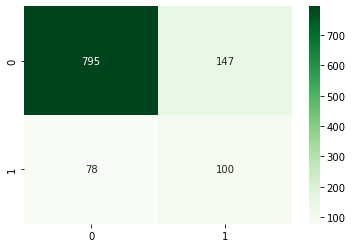

In [56]:
# faccio la predizione e stampo le statistiche sul modello migliore (quello che ha vinto nella GridSearch)

y_pred = clf.predict(X_test)
#print(clf.predict_proba(X_test)) # per vedere le probabilita' con cui sono classificati come ponzi o non ponzi
print('precision score:: ', precision_score(y_test, y_pred)) # TP / (FP + TP)
print('recall score:: ', recall_score(y_test, y_pred))	     # TP / (FN + TP)
print('accuracy score:: ', accuracy_score(y_test, y_pred))	 # (TP + TN)/ (TP + FN + TN + FP)
print('F1 score::', f1_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d')